In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import math
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

# Import our adaptive module:
from adaptive_MDP import Adaptive
from non_adaptive import NonAdaptive

In [2]:
# Initial parameters
mu = 0.00015
gamma = 0.0027
beta = 0.009
phi = 0.0044

kappa = 0.8  #C^I/C^S
xi = 1.7 #C^Z/C^S

# R values:
Rmu = mu/(mu+ gamma)
Rphi = phi/(mu + gamma)

### Adaptive parameters
bs = 10
bi = kappa*bs
bz = xi*bs
ai = 1.826
az = 0
as1 = 0 
gamma1 = 0.25
tau = 12
delta = 0.99986

### Simulation parameters
t_max = 5000
steps = 100
x00 = [0.9, 0.05, 0.05]
# Note: our start point is not [1,0,0]
# Because the disease-free equilibrium is stable for models with demographics.

# Initialize adaptive instances
instance_adaptive = Adaptive(mu, gamma, beta, phi,
                             bs, bi, bz, 
                             as1, ai, az,
                             gamma1, tau, delta,
                             t_max, steps, x00)
start = time.time()
instance_adaptive.patch_uni_solutions()
end = time.time()
print(f"Running the adaptive algorithm took {end - start} seconds.")

# To compare, we take the Cs obtained at the end of this algorithm.
Cs = instance_adaptive.Cs[len(instance_adaptive.Cs)-1]
# Initialize non adaptive instances
instance_non_adaptive = NonAdaptive(mu, gamma, beta, phi,
                                    Cs, Cs*kappa, Cs*xi,
                                    t_max, steps, x00)
start = time.time()
instance_non_adaptive.solve_odes_system()
end = time.time()
print(f"Running the NON adaptive algorithm took {end - start} seconds.")

Running the adaptive algorithm took 152.54998874664307 seconds.
Running the NON adaptive algorithm took 0.0010886192321777344 seconds.


Plot the adaptive solution:

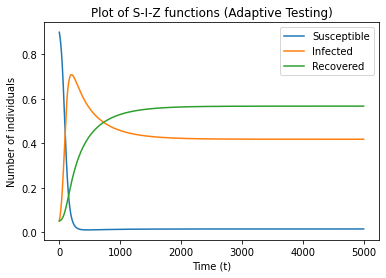

In [3]:
t = np.linspace(0, instance_adaptive.t_max, len(instance_adaptive.S))
instance_adaptive.plot_ode_solution(t = t, title = 'Adaptive Testing')

5000


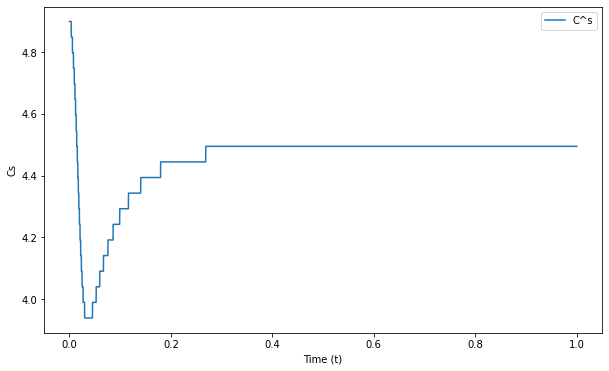

In [4]:
print(len(instance_adaptive.Cs))
cs_unistep = []
for i in range(len(instance_adaptive.Cs)):
    cs_unistep = cs_unistep + [instance_adaptive.Cs[i]]*steps
    
plt.plot(np.linspace(0,1,len(cs_unistep)), cs_unistep, label="C^s")
plt.xlabel("Time (t)")
plt.ylabel("Cs")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

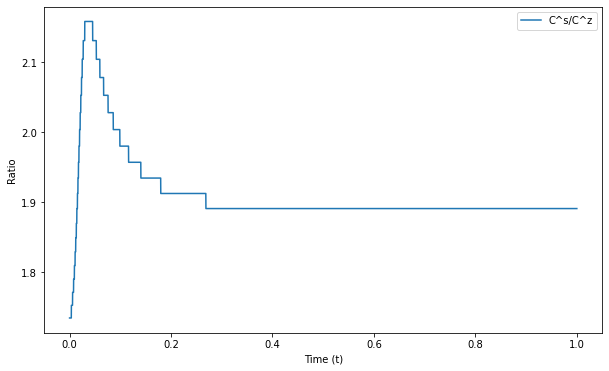

In [5]:
cs_unistep = []
for i in range(len(instance_adaptive.Cs)):
    cs_unistep = cs_unistep + [0.5*instance_adaptive.bz/instance_adaptive.Cs[i]]*steps
    
plt.plot(np.linspace(0,1,len(cs_unistep)), cs_unistep, label="C^s/C^z")
plt.xlabel("Time (t)")
plt.ylabel("Ratio")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

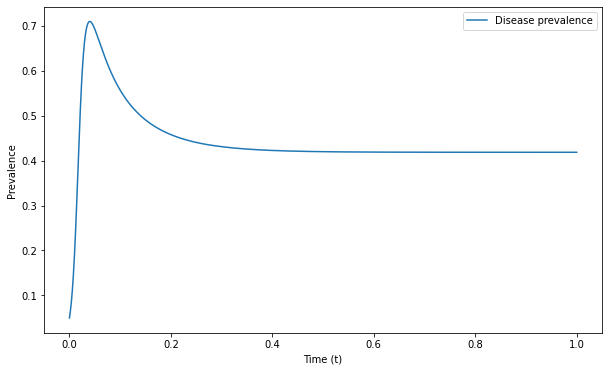

In [6]:
plt.plot(np.linspace(0,1,len(instance_adaptive.I)), instance_adaptive.I, label="Disease prevalence")
plt.xlabel("Time (t)")
plt.ylabel("Prevalence")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

Plot the Non adaptive solution:

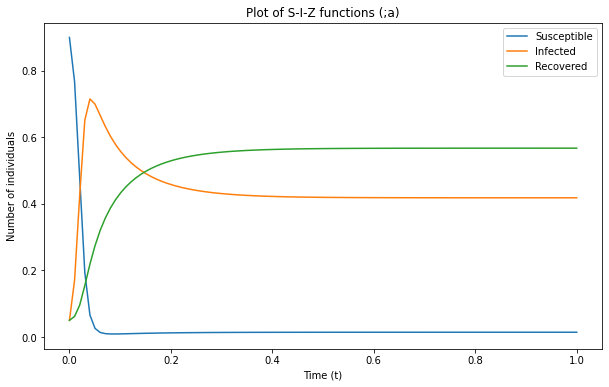

In [7]:
instance_non_adaptive.plot_ode_solution(
    t = np.linspace(0,1,len(instance_non_adaptive.S)), title = ';a')

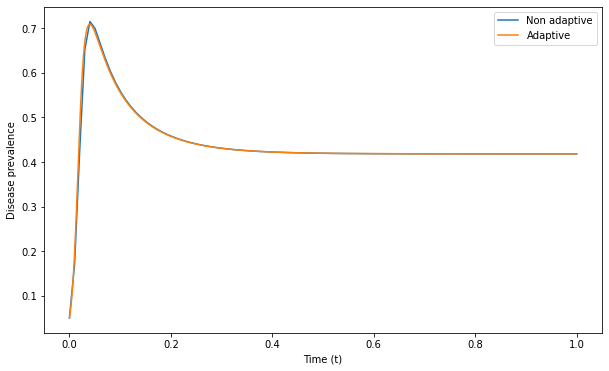

In [8]:
plt.plot(np.linspace(0,1,len(instance_non_adaptive.S)), instance_non_adaptive.I, label="Non adaptive")
plt.plot(np.linspace(0,1,len(instance_adaptive.I)), instance_adaptive.I, label="Adaptive")
plt.xlabel("Time (t)")
plt.ylabel("Disease prevalence")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

Comments:

1. When the adaptive converges, then it will converge to the same point as the constant system that uses the contact rates of the adaptive system at the equilibrium. This is because if we have convergence in the adaptive setting, then from certain point onwards there will be no change in the state of the system and all the adaptive considerations will be deleted and the system will behave as a system with constant contact rates.

2. A big question is: when will the adaptive system converge to an equilibrium point? Can we find conditions to ensure this? Is the initial state of the system a key factor that determines this behavior?